# Wczytujemy potrzebne biblioteki:

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

# Wczytujemy dane z FASHION_MNIST:

In [9]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


# Mała wizualizacja przykładowych obrazów:

NameError: name 'train_images' is not defined

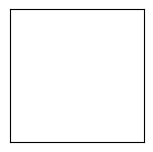

In [14]:
# Nazwy klas (dla wygody)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
               #DOKUMENTACJA ZBIORU DANYCH: https://www.tensorflow.org/datasets/catalog/fashion_mnist

# Wyświetl 25 pierwszych obrazków
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [ ]:
# Funkcja implementująca STE
@tf.custom_gradient
def quantize_ste(x):
  """
  Kwantyzuje wejście float [0, 1] do 8-bitowej precyzji (jako float)
  i używa Straight-Through Estimator dla gradientu.
  """
  # W przód: kwantyzacja
  # 1. Skaluj [0, 1] -> [0, 255]
  # 2. Zaokrąglij do najbliższej liczby całkowitej
  # 3. Skaluj z powrotem [0, 255] -> [0, 1]
  x_quantized = tf.round(x * 255.0) / 255.0

  # W tył: gradient (prosty estymator)
  def grad(dy):
    # Przekaż gradient bez zmian, tak jakby ta warstwa była tożsamością
    return dy

  return x_quantized, grad

# Niestandardowa warstwa Keras
class QuantizationLayer(layers.Layer):
  def __init__(self, **kwargs):
    super(QuantizationLayer, self).__init__(**kwargs)

  def call(self, inputs):
    return quantize_ste(inputs)

# Budowana modelu: system sub-klas


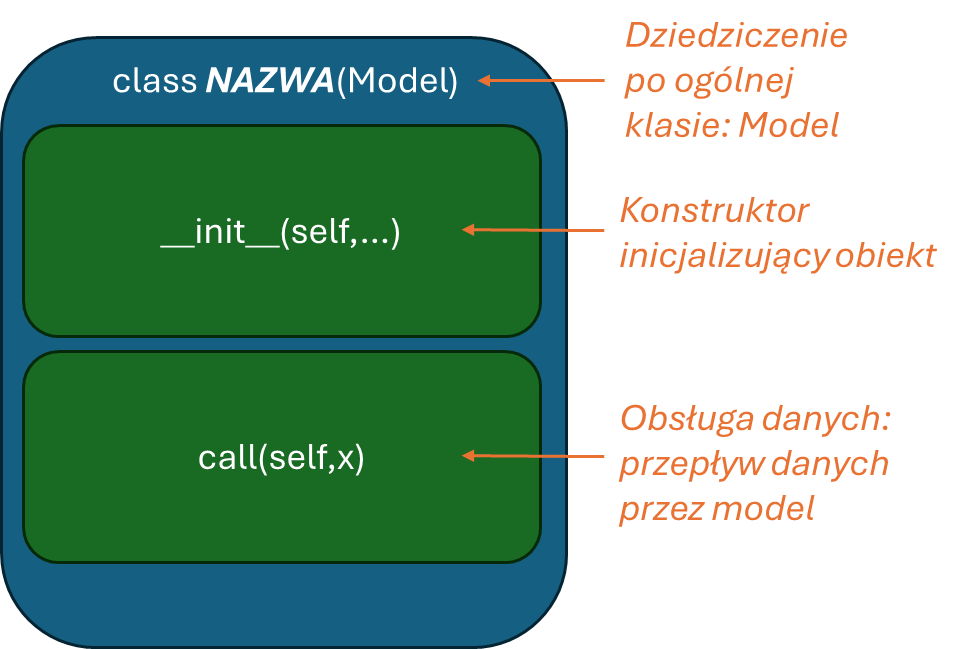

In [ ]:
class QuantizedAutoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(QuantizedAutoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape

    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(2 * latent_dim, activation='relu'),
      # Ostatnia warstwa encodera daje wyjście [0, 1]
      layers.Dense(latent_dim, activation='sigmoid'),
    ])

    # Warstwa kwantyzacji
    self.quantizer = QuantizationLayer()

    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    quantized = self.quantizer(encoded) # Kwantyzacja dzieje się tutaj
    decoded = self.decoder(quantized)
    return decoded

# Inicjalizacja
shape = x_test.shape[1:]
latent_dim = 64
quantized_ae = QuantizedAutoencoder(latent_dim, shape)

quantized_ae.compile(optimizer='adam', loss=losses.MeanSquaredError())
# Teraz model można trenować

In [ ]:
# kompilacja (zauważ, nie musieliśmy jej implementować...):
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
# trening: 
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

- Jaki jest poziom uzyskanej kompresji? 
- Jak wyeksportować składowe AutoEncodera na kompresor i dekompresor?
- Dlaczego modele Encodera i Decodera nie mają zdefiniowanych rozmiarów wejściowych(InputLayer zakomentowany)? Jak to będzie ostatecznie działać po wytrenowaniu modelu?
- ***Jakie metryki jakości można by dodać, aby kontrolować jakość obrazu po rekonstrukcji? Jak zaimplementować je do procesu uczenia jako <metrics>? 